In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_melanoma.h5ad')
adata

AnnData object with n_obs × n_vars = 4804 × 3392
    obs: 'X', 'Y', 'cell_type', 'author_cell_type', 'cell_type_int'
    uns: 'author_cell_type_colors', 'cell_type_colors', 'cell_type_int_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [4]:
import sys
sys.path.append('../../src')
sys.path.append('..')

In [5]:
import celloracle as co
%matplotlib inline


In [23]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata, min_dist=0.5, spread=0.5)

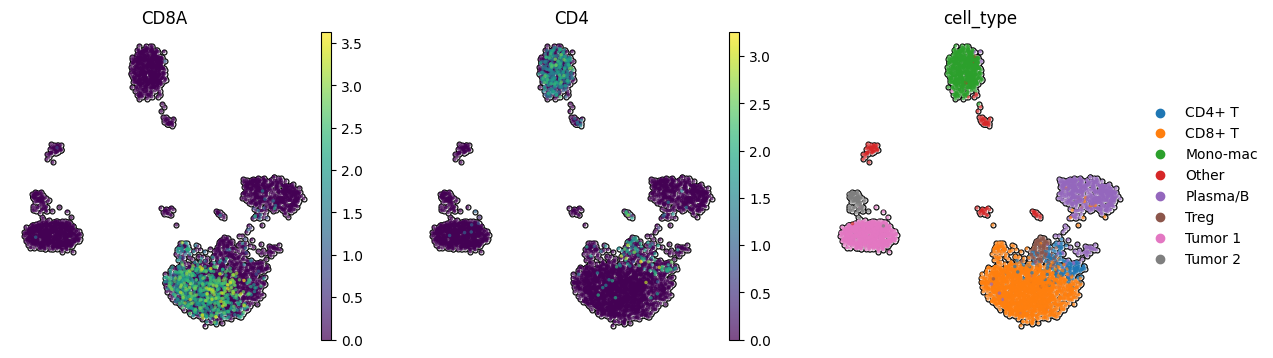

In [29]:
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 100

sc.pl.umap(
    adata, 
    color=['CD8A', 'CD4', 'cell_type'], 
    frameon=False, 
    linewidth=0.1, 
    edgecolor='black',
    add_outline=True,
)

In [30]:
adata.X.max()

8.132702

In [31]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

In [32]:
adata.layers["raw_count"].max(), adata.layers["raw_count"].mean()

(3402.9844, 0.6135156)

In [33]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [34]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [35]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 8/8 [07:53<00:00, 59.16s/it]

CPU times: user 4min 40s, sys: 14.1 s, total: 4min 54s
Wall time: 7min 53s


In [36]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [37]:
oracle.fit_GRN_for_simulation(
    alpha=1,
    use_cluster_specific_TFdict=True
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
# goi = 'FOXO1'
# oracle.simulate_shift(
#     perturb_condition={goi: 0},
#     n_propagation=4
# )

In [29]:
# oracle.adata.to_df(layer='simulated_count').to_csv('celloracle_FOXO1_KO.csv')

In [39]:
import pickle

with open('/Users/koush/Desktop/training_data/snrna_human_melanoma_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

: 

In [21]:

# links.to_hdf5(file_path="/tmp/links.celloracle.links")
# oracle.to_hdf5("/tmp/tonsil.celloracle.oracle")